## Import Statements

In [21]:
from sklearn.svm import SVC
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from itertools import product
from gensim.models import Word2Vec
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

# Load and check data

In [22]:
train = pd.read_csv("./train.csv")
test_x = pd.read_csv("./test_x.csv")

print("Number of rows in train DataFrame:", train.shape[0])
train

Number of rows in train DataFrame: 5329


,id,keyword,location,text,target
0,2115,catastrophe,Florida,@deb117 7/30 that catastrophe man opens school...,0
1,9232,suicide%20bombing,NaN,meek mill should join isis since he loves suic...,0
2,8131,rescued,Ireland,Three beached whales rescued in Kerry - http:/...,1
3,8236,riot,Seattle,Southeast Dirt Riot Series Crowns Champions: ...,0
4,9822,trauma,NaN,Hiroshima: They told me to paint my story: Eig...,1
...,...,...,...,...,...
5324,6371,hostages,Germany,@banditregina I also loved the episode 'Bang' ...,0
5325,9388,survived,"Austin, TX",Survived Spanish!! @ Sweet Ritual https://t.co...,0
5326,5366,fire%20truck,United States,#RFP: Fire Truck Service Body for F-450 (Fire ...,0
5327,479,armageddon,NaN,So the Ahamedis think the Messiah had already ...,0


## Data Preprocessing

In [23]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Example: URL removal
def remove_url(data):
    re1 = r"http://\S+|www\.\S+"
    re2 = r"https://\S+|www\.\S+"
    url_clean= re.compile("(%s|%s)" % (re1, re2))
    data=url_clean.sub(r'',data)
    return data

def to_lowercase(data):
    return data.lower()

def remove_hashtag(data):
    return re.sub(r'#', '', data)

def remove_special(data):
    return re.sub(r'[^A-Za-z0-9\s]', '', data)

def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(data)
    return ' '.join([lemmatizer.lemmatize(word) 
                     for word in tokens 
                     if word not in stop_words])

# Apply Preprocessing
def preprocess(data):
    data['text'] = data['text'].apply(remove_url)
    data['text'] = data['text'].apply(to_lowercase)
    data['text'] = data['text'].apply(remove_hashtag)
    data['text'] = data['text'].apply(remove_special)
    data['text'] = data['text'].apply(lemmatize)
    return data

print('before removal: ', train.iloc[5325]['text'])

# Apply preprocessing
train = preprocess(train)
test_x = preprocess(test_x)

print('after removal: ', train.iloc[5325]['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rootsourav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rootsourav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/rootsourav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


before removal:  Survived Spanish!! @ Sweet Ritual https://t.co/inIqzfyioi
after removal:  survived spanish sweet ritual


Function to save file predictions

In [24]:
def save_predictions(test_x, test_predictions, file_name):
    """
    Save predictions to a CSV file.

    Parameters:
    - test_x: DataFrame, input data for predictions
    - test_predictions: Series, the predicted values
    - file_name: str, the name of the CSV file to save
    """
    y_pred = pd.DataFrame({
        'id': test_x['id'],
        'target': test_predictions
    })

    y_pred.to_csv(file_name, index=False)
    print(f"Predictions saved to {file_name}")
    return y_pred.head(3)

# Classification based on bag-of-word text features

In [25]:
# This package generates bag of words feature for each text

# doc for this function: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# vectorizer = CountVectorizer(stop_words='english', max_df=1.0, min_df=1, max_features=10000)
vectorizer = CountVectorizer(stop_words='english', max_df=1.0, min_df=5, max_features=10000) 

# use training data to construct vocabulary and turn training text into BOW vectors
train_bow = vectorizer.fit_transform(train['text'])
vocab = vectorizer.vocabulary_.copy()
# You can change the vocab size by tuning "max_df", "min_df" or "max_features" in "CountVectorizer"
print('vocab size: ', len(vocab))  
print (train_bow.shape) # num_train_text * vocab_size

# !!! YOUR TASK 2 (1 point): transform test text into BOW vectors using vectorizer
test_bow = vectorizer.transform(test_x['text'])
print (test_bow.shape) # num_train_text * vocab_size

vocab size:  1807
(5329, 1807)
(2284, 1807)


## RandomForest Classifier

In [26]:
# Use basic ML models on BOW features

# Split given training data into training and validation set
X_train,X_val,y_train,y_val = train_test_split(train_bow, train['target'], test_size=0.3, random_state=11)

LR = RandomForestClassifier()
LR.fit(X_train.toarray(),y_train)

# Make predictions on the training and validation sets
train_predictions = LR.predict(X_train.toarray())
val_predictions = LR.predict(X_val.toarray())

# Calculate and print accuracy, F1 score and recall for training set
train_accuracy = accuracy_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)

print('Training Accuracy: ', train_accuracy)
print('Training F1 Score: ', train_f1)
print('Training Recall: ', train_recall)

# Calculate and print accuracy, F1 score and recall for validation set
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)

print('Validation Accuracy: ', val_accuracy)
print('Validation F1 Score: ', val_f1)
print('Validation Recall: ', val_recall)

# testing on test set
test_predictions_RF = LR.predict(test_bow.toarray())

save_predictions(test_x, test_predictions_RF, "RF.csv")

Training Accuracy:  0.9804289544235925
Training F1 Score:  0.9770512417478779
Training Recall:  0.9682242990654205
Validation Accuracy:  0.7623514696685428
Validation F1 Score:  0.708141321044547
Validation Recall:  0.6839762611275965
Predictions saved to RF.csv


,id,target
0,4659,1
1,1072,0
2,2559,1


## RandomForest Classifier with GridSearchCv

In [27]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_bow, train['target'], test_size=0.3, random_state=11)

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring metrics for optimization
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, refit='f1', cv=3)
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=3)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, refit='recall', cv=3)

# Fit the grid search to the data
grid_search.fit(X_train.toarray(), y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the training set
train_predictions = best_model.predict(X_train.toarray())
train_accuracy = accuracy_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)

# Print the evaluation metrics on the training set
print('Training Accuracy:', train_accuracy)
print('Training F1 Score:', train_f1)
print('Training Recall:', train_recall)

# Evaluate the best model on the validation set
val_predictions = best_model.predict(X_val.toarray())
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)

# Print the evaluation metrics on the validation set
print('Validation Accuracy:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Recall:', val_recall)

# Use the best model to predict the test set
test_predictions_RF_GS_CV = best_model.predict(test_bow.toarray())
save_predictions(test_x, test_predictions_RF_GS_CV, "RF_GridSearchCV.csv")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training Accuracy: 0.9482573726541556
Training F1 Score: 0.9379620700739312
Training Recall: 0.9090342679127725
Validation Accuracy: 0.7754846779237023
Validation F1 Score: 0.7188723570869227
Validation Recall: 0.6810089020771514
Predictions saved to RF_GridSearchCV.csv


,id,target
0,4659,1
1,1072,0
2,2559,1


# Classification based on word2vec embedding features

In [28]:
# train word embeddings using gensim library

train_docs = [train['text'].iloc[i].split(' ') for i in range(len(train['text']))] # gensim only takes list of word list as `sentences`
w2v_model = Word2Vec(sentences=train_docs, vector_size=100, window=5, negative=20, min_count=2, workers=1)
w2v_model.train(train_docs, total_examples=len(train_docs), epochs=10)

(411031, 499100)

In [29]:
# check the learned word embeddings

# vocabulary
w2v_vocav = w2v_model.wv.index_to_key
print('example words in vocab: ', [w2v_vocav[i] for i in range(200)])

# example embedding
example_word = 'bomb'
word_vec = w2v_model.wv[example_word]
print('learned embedding of bomb: ', word_vec)

# !!! YOUR TASK (2 point): show the top-10 words most similar to 'bomb'
# you may calculate manually, or refer to gensim function: https://radimrehurek.com/gensim/models/word2vec.html
similar_words = w2v_model.wv.most_similar('bomb', topn=10)
print('Top-10 words most similar to "bomb":')
for word, similarity in similar_words:
    print(f'{word}: {similarity:.4f}')

# !!! Your TASK (1 point): tune the arguments of Word2Vec to obtain different word embeddings
# and show top-10 similar words as ''bomb''
# Experiment with different hyperparameter values
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=150, window=10, negative=10, min_count=5, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')

example words in vocab:  ['fire', 'like', 'im', 'amp', 'get', 'u', 'new', 'via', 'news', 'people', 'dont', 'one', 'video', 'emergency', '2', 'body', 'police', 'building', 'time', 'disaster', 'family', 'year', 'day', 'say', 'home', 'california', 'life', 'go', 'storm', 'burning', 'crash', 'got', 'love', 'train', 'still', 'back', 'man', 'death', 'would', 'suicide', 'world', 'flood', 'attack', 'car', 'cant', 'see', 'know', 'going', 'today', '3', 'first', 'bomb', 'look', 'accident', 'rt', 'nuclear', 'killed', 'youtube', 'full', 'need', 'dead', 'two', 'woman', 'want', 'think', 'make', 'war', 'take', 'wildfire', 'plan', 'way', 'bag', 'hiroshima', 'could', 'bombing', 'let', 'many', 'watch', 'last', 'weapon', 'right', 'may', 'service', 'best', 'good', 'work', 'na', 'thing', 'really', 'fatal', 'injury', 'youre', 'state', 'hit', 'read', 'mass', 'mh370', 'lol', 'help', 'even', 'school', 'god', 'water', 'feel', 'come', 'much', 'forest', 'another', 'black', 'collapse', 'pm', 'house', 'legionnaire', 

# Experiment with different hyper-parameter values

Changing the Vector Size

In [30]:
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=200, window=10, negative=10, min_count=5, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9575
old: 0.9404
army: 0.9174
bombed: 0.9166
since: 0.9157
atomic: 0.9096
hiroshima: 0.9077
detonated: 0.9053
japan: 0.9041
turkey: 0.9040


Changing the Window Size

In [31]:
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=150, window=15, negative=10, min_count=5, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9463
old: 0.9397
hiroshima: 0.9131
since: 0.8971
japan: 0.8970
bombed: 0.8970
atomic: 0.8940
anniversary: 0.8871
turkey: 0.8867
army: 0.8854


Changing the Negative Sampling

In [32]:
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=200, window=10, negative=5, min_count=5, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9835
hiroshima: 0.9512
atomic: 0.9430
old: 0.9379
japan: 0.9359
nagasaki: 0.9251
army: 0.9238
suicide: 0.9218
anniversary: 0.9169
struggle: 0.9167


Changing the Minimum Count

In [33]:
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=200, window=10, negative=10, min_count=4, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9593
old: 0.9474
atomic: 0.9198
hiroshima: 0.9167
since: 0.9124
japan: 0.9083
bombed: 0.9071
turkey: 0.9036
army: 0.9014
anniversary: 0.9013


Changing the Number of Workers

In [34]:
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=150, window=10, negative=10, min_count=5, workers=8)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)

# Top-10 words most similar to 'bomb' with tuned parameters
similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9544
old: 0.9400
atomic: 0.9202
hiroshima: 0.9170
turkey: 0.9084
since: 0.9026
bombed: 0.9018
mark: 0.8970
bestnaijamade: 0.8964
anniversary: 0.8927


Manual Grid Search for word2vec hyper parameters

In [35]:
# Define parameter grids to search
vector_sizes = [100, 150, 200]
windows = [5, 10, 15]
negatives = [5, 10, 15]
min_counts = [1, 3, 5]

# Perform manual grid search
best_model = None
best_similarity_score = -1  # Initialize with a low value

iterations = 0
total_iterations = len(vector_sizes) * len(windows) * len(negatives) * len(min_counts)

for vector_size, window, negative, min_count in product(vector_sizes, windows, negatives, min_counts):
    iterations += 1
    print(f'\nIteration {iterations}/{total_iterations}')
    print(f'\nTraining model with vector_size={vector_size}, window={window}, negative={negative}, min_count={min_count}')

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=train_docs, vector_size=vector_size, window=window, negative=negative, min_count=min_count, workers=4)
    w2v_model.train(train_docs, total_examples=len(train_docs), epochs=10)

    # Evaluate similarity with the word 'bomb'
    similar_words = w2v_model.wv.most_similar('bomb', topn=10)  # Adjust topn as needed
    similarity_score = sum([similarity for word, similarity in similar_words]) / len(similar_words)

    # Update best model if the current one performs better
    if similarity_score > best_similarity_score:
        best_similarity_score = similarity_score
        best_model = w2v_model

# Print the best parameters
print("\nBest parameters:", best_model.vector_size, best_model.window, best_model.negative, best_model.min_count)

# Print the words most similar to 'bomb' from the best model
print("Words most similar to 'bomb':")
for word, similarity in best_model.wv.most_similar('bomb', topn=10):
    print(f'{word}: {similarity:.4f}')



Iteration 1/81

Training model with vector_size=100, window=5, negative=5, min_count=1

Iteration 2/81

Training model with vector_size=100, window=5, negative=5, min_count=3

Iteration 3/81

Training model with vector_size=100, window=5, negative=5, min_count=5

Iteration 4/81

Training model with vector_size=100, window=5, negative=10, min_count=1

Iteration 5/81

Training model with vector_size=100, window=5, negative=10, min_count=3

Iteration 6/81

Training model with vector_size=100, window=5, negative=10, min_count=5

Iteration 7/81

Training model with vector_size=100, window=5, negative=15, min_count=1

Iteration 8/81

Training model with vector_size=100, window=5, negative=15, min_count=3

Iteration 9/81

Training model with vector_size=100, window=5, negative=15, min_count=5

Iteration 10/81

Training model with vector_size=100, window=10, negative=5, min_count=1

Iteration 11/81

Training model with vector_size=100, window=10, negative=5, min_count=3

Iteration 12/81

Trai

Testing HyperParameter values of the best model achieved from parameter-grid-search 

In [36]:
# Best parameters: vector_size=200, window=5, negative=5, min_count=1
w2v_model_tuned = Word2Vec(sentences=train_docs, vector_size=200, window=5, negative=5, min_count=1, workers=4)
w2v_model_tuned.train(train_docs, total_examples=len(train_docs), epochs=15)


similar_words_tuned = w2v_model_tuned.wv.most_similar('bomb', topn=10)
print('\nTop-10 words most similar to "bomb" with tuned parameters:')
for word, similarity in similar_words_tuned:
    print(f'{word}: {similarity:.4f}')


Top-10 words most similar to "bomb" with tuned parameters:
bombing: 0.9938
turkey: 0.9902
bestnaijamade: 0.9893
detonated: 0.9849
trench: 0.9823
vest: 0.9810
responsibility: 0.9808
suicide: 0.9789
pkk: 0.9784
saudi: 0.9779


## Choice 1

In [37]:
# Replace with the actual best Word2Vec model
best_w2v_model = w2v_model_tuned  

# Choice 1 (as shown below): manually take the average of word embeddings in each document
def doc2vec_choice1(docs, w2v_model):
    w2v = []
    for doc in docs:
        word_embs = [w2v_model.wv[w] for w in doc if w in w2v_model.wv] # get a list of word embeddings
        
        # TODO: take (weighted) average to get doc embedding
        doc_emb = np.mean(np.array(word_embs), axis=0) 
        
        # filling zeros for empty doc
        if len(word_embs) == 0:
            doc_emb = [0 for i in range(w2v_model.vector_size)]
        
        w2v.append(doc_emb)
    
    return np.array(w2v)

# Transform training tweets into embeddings using Choice 1
train_w2v_choice1 = doc2vec_choice1(train_docs, best_w2v_model)
print('Training word2vec (Choice 1) shape:', train_w2v_choice1.shape)

# Transform test tweets into embeddings using Choice 1
test_w2v_choice1 = doc2vec_choice1(test_x['text'], best_w2v_model)
print('Test word2vec (Choice 1) shape:', test_w2v_choice1.shape)

# Split for Choice 1
X_train_choice1, X_val_choice1, y_train_choice1, y_val_choice1 = train_test_split(
    train_w2v_choice1, train['target'], test_size=0.3, random_state=11
)


Training word2vec (Choice 1) shape: (5329, 200)
Test word2vec (Choice 1) shape: (2284, 200)


Logistic Regression on choice 1

In [38]:
# Use a Logistic Regression classifier
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

logistic_model.fit(X_train_choice1, y_train_choice1)

# Make predictions on the validation set
y_pred_logistic = logistic_model.predict(X_val_choice1)

# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(y_val_choice1, y_pred_logistic)
f1_logistic = f1_score(y_val_choice1, y_pred_logistic)
recall_logistic = recall_score(y_val_choice1, y_pred_logistic)

print('Accuracy on the validation set (Logistic Regression):', accuracy_logistic)
print('F1 Score on the validation set (Logistic Regression):', f1_logistic)
print('Recall on the validation set (Logistic Regression):', recall_logistic)

word2vec_test_predictions_choice1 = logistic_model.predict(doc2vec_choice1([test_x['text'].iloc[i].split(' ') for i in range(len(test_x['text']))], best_w2v_model))
save_predictions(test_x, word2vec_test_predictions_choice1, "word2vec_LR_choice1.csv")

Accuracy on the validation set (Logistic Regression): 0.7229518449030644
F1 Score on the validation set (Logistic Regression): 0.587906976744186
Recall on the validation set (Logistic Regression): 0.4688427299703264
Predictions saved to word2vec_LR_choice1.csv


/home/rootsourav/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rootsourav/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,id,target
0,4659,0
1,1072,0
2,2559,0


RandomForest on choice 1

In [39]:
# Use a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(X_train_choice1, y_train_choice1)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_choice1)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_val_choice1, y_pred_rf)
f1_rf = f1_score(y_val_choice1, y_pred_rf)
recall_rf = recall_score(y_val_choice1, y_pred_rf)

print('Accuracy on the validation set (Random Forest):', accuracy_rf)
print('F1 Score on the validation set (Random Forest):', f1_rf)
print('Recall on the validation set (Random Forest):', recall_rf)

word2vec_test_predictions_choice1_RF = rf_model.predict(doc2vec_choice1([test_x['text'].iloc[i].split(' ') for i in range(len(test_x['text']))], best_w2v_model))
save_predictions(test_x, word2vec_test_predictions_choice1_RF, "word2vec_RF_choice1.csv")

Accuracy on the validation set (Random Forest): 0.7373358348968105
F1 Score on the validation set (Random Forest): 0.6528925619834711
Recall on the validation set (Random Forest): 0.586053412462908
Predictions saved to word2vec_RF_choice1.csv


/home/rootsourav/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rootsourav/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,id,target
0,4659,1
1,1072,0
2,2559,1


RandomForest with GridSearchCV on choice 1

In [24]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train_choice1, y_train_choice1)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for predictions
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_val_choice1)

# Evaluate the best model
accuracy_best = accuracy_score(y_val_choice1, y_pred_best)
f1_best = f1_score(y_val_choice1, y_pred_best)
recall_best = recall_score(y_val_choice1, y_pred_best)

print('Metrics on the validation set (Random Forest):')
print('Accuracy :', accuracy_best)
print('F1 Score :', f1_best)
print('Recall :', recall_best)

word2vec_test_predictions_choice1_RF_GS_CV = best_rf_model.predict(doc2vec_choice1(
    [test_x['text'].iloc[i].split(' ') for i in range(len(test_x['text']))], best_w2v_model))
save_predictions(test_x, word2vec_test_predictions_choice1_RF_GS_CV, "word2vec_RF_GS_CV_choice1.csv")

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy on the validation set (Best Model): 0.7485928705440901
F1 Score on the validation set (Best Model): 0.6587436332767402
Recall on the validation set (Best Model): 0.5756676557863502


## Choice 2: Gensim Doc2Vec

In [40]:
# Tagging documents with IDs
train_tagged = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(train_docs)]
test_tagged = [TaggedDocument(words=doc.split(' '), tags=[i]) for i, doc in enumerate(test_x['text'])]

# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
# doc2vec_model = Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, epochs=40)
doc2vec_model.build_vocab(train_tagged)
doc2vec_model.train(train_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Create document embeddings
train_d2v = np.array([doc2vec_model.dv[i] for i in range(len(train_tagged))])
test_d2v = np.array([doc2vec_model.infer_vector(doc.words) for doc in test_tagged])

# Split data for training and validation
X_train_d2v, X_val_d2v, y_train, y_val = train_test_split(train_d2v, train['target'], test_size=0.3, random_state=11)

Logistic Regression on choice 2

In [41]:
# Apply a Logistic Regression model on Doc2Vec embeddings
lr_model_d2v = LogisticRegression()
lr_model_d2v.fit(X_train_d2v, y_train)

# predictions on validation set
y_val_pred_d2v = lr_model_d2v.predict(X_val_d2v)

# Calculate and print metrics for Doc2Vec model
print('Doc2Vec Validation Accuracy:', accuracy_score(y_val, y_val_pred_d2v))
print('Doc2Vec Validation Recall:', recall_score(y_val, y_val_pred_d2v))
print('Doc2Vec Validation F1-Score:', f1_score(y_val, y_val_pred_d2v))

# Predict on test set
test_predictions_choice2_LR = lr_model_d2v.predict(test_d2v)
save_predictions(test_x, test_predictions_choice2_LR, "Doc2Vec_LR_choice2.csv")

Doc2Vec Validation Accuracy: 0.7592245153220762
Doc2Vec Validation Recall: 0.6320474777448071
Doc2Vec Validation F1-Score: 0.6887631366208569
Predictions saved to Doc2Vec_LR_choice2.csv


,id,target
0,4659,1
1,1072,0
2,2559,0


RandomForest with GridSearchCV on choice 2

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_model_choice2 = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_choice2, param_grid=param_grid, scoring='f1', cv=5)

# Train the model with GridSearchCV
grid_search.fit(X_train_d2v, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

# Evaluate the model
y_train_pred_rf = best_rf.predict(X_train_d2v)
y_val_pred_rf = best_rf.predict(X_val_d2v)

# Performance metrics
print('Choice 2 - Random Forest Validation Accuracy:', accuracy_score(y_val, y_val_pred_rf))
print('Choice 2 - Random Forest Validation Recall:', recall_score(y_val, y_val_pred_rf))
print('Choice 2 - Random Forest Validation F1-Score:', f1_score(y_val, y_val_pred_rf))

# Predict on test set and save predictions
test_predictions_choice2_RF_GSCV = best_rf.predict(test_d2v)
save_predictions(test_x, test_predictions_choice2_RF_GSCV, "Doc2Vec_RF_choice2.csv")

Support Vector Machine (SVM) on Choice 2

In [80]:
# Initialize and train the SVM model for Choice 2
svm_model_choice2 = SVC()
svm_model_choice2.fit(X_train_d2v, y_train)

# Evaluate the model
y_train_pred_svm2 = svm_model_choice2.predict(X_train_d2v)
y_val_pred_svm2 = svm_model_choice2.predict(X_val_d2v)

# Performance metrics
print('Choice 2 - SVM Validation Accuracy:', accuracy_score(y_val, y_val_pred_svm2))
print('Choice 2 - SVM Validation Recall:', recall_score(y_val, y_val_pred_svm2))
print('Choice 2 - SVM Validation F1-Score:', f1_score(y_val, y_val_pred_svm2))

test_predictions_choice2_SVM = svm_model_choice2.predict(test_d2v)
save_predictions(test_x, test_predictions_choice2_SVM, "Doc2Vec_SVM_choice2.csv")

Choice 2 - SVM Validation Accuracy: 0.7598499061913696
Choice 2 - SVM Validation Recall: 0.6216617210682492
Choice 2 - SVM Validation F1-Score: 0.685761047463175
Predictions saved to Doc2Vec_SVM_choice2.csv


,id,target
0,4659,1
1,1072,0
2,2559,1


## Classification directly using RNN model

Tokenization and Vocabulary Building

In [42]:
# Tokenization and Vocabulary Building
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Common Parameters for training

In [43]:
vocab_size = len(vocab)
batch_size = 32
num_epochs = 30
output_size = 2  # Binary classification

RNN architecture

In [44]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, num_layers=1, batch_first=True, nonlinearity='relu')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1])
        logits = self.fc(hidden)
        return logits

# Hyperparameters
embed_dim = 100
hidden_size = 100
learning_rate = 0.001
dropout = 0.5
weight_decay = 1e-5

# Model Initialization
model = RNNModel(vocab_size, embed_dim, hidden_size, output_size, dropout)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

LSTM architecture (model 1)

In [7]:
# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        logits = self.fc(output[:, -1, :])
        return logits

# # Hyperparameters
embed_dim = 128
hidden_size = 128
num_layers = 1
learning_rate = 0.001
dropout=0.5

# Model Initialization
model = LSTMModel(vocab_size, embed_dim, hidden_size, output_size,num_layers,dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/rootsourav/miniconda3/envs/tf/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM architecture (model 2)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True, 
                            dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden state
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:]
        logits = self.fc(hidden)
        return logits

# Update Hyperparameters
embed_dim = 128
hidden_size = 128
num_layers = 2
learning_rate = 0.0005
dropout = 0.3
weight_decay = 1e-4

# Model Initialization
model = LSTMModel(vocab_size, embed_dim, hidden_size, output_size, num_layers=num_layers, bidirectional=True, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Data Prep

In [45]:
# Convert Text to Tensor Function
def text_to_tensor(text):
    return torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long)

# Split Data into Training and Validation
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
train_data['text_tensor'] = train_data['text'].apply(text_to_tensor)
val_data['text_tensor'] = val_data['text'].apply(text_to_tensor)

Training Loop

Epoch 1/30, Training Loss: 0.021657129981667116, Validation Loss: 0.021888975913708027
Epoch 2/30, Training Loss: 0.02140776085624274, Validation Loss: 0.021895142869698844
Epoch 3/30, Training Loss: 0.02119810651675821, Validation Loss: 0.02197851713110761
Epoch 4/30, Training Loss: 0.021043176539705416, Validation Loss: 0.02206455347238294
Epoch 5/30, Training Loss: 0.020771987877791404, Validation Loss: 0.02226162722813032
Epoch 6/30, Training Loss: 0.02053849520382399, Validation Loss: 0.02222766566455476
Epoch 7/30, Training Loss: 0.02033426402712998, Validation Loss: 0.022889430594489005
Epoch 8/30, Training Loss: 0.020258240504861018, Validation Loss: 0.02218398949442393
Epoch 9/30, Training Loss: 0.020024073325270585, Validation Loss: 0.022595880682428154
Epoch 10/30, Training Loss: 0.019473097958028974, Validation Loss: 0.02291553211704204
Epoch 11/30, Training Loss: 0.01908003747001825, Validation Loss: 0.023281993774267342
Epoch 12/30, Training Loss: 0.018527877467452655, Va

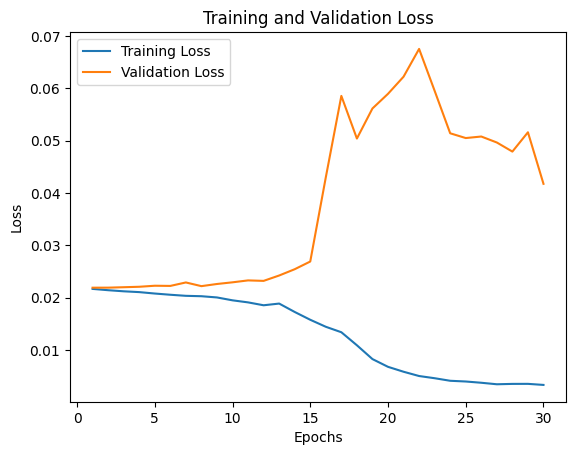

Final Training Metrics: Accuracy: 0.9660, Recall: 0.9652, F1-Score: 0.9652
Final Validation Metrics: Accuracy: 0.5000, Recall: 0.5179, F1-Score: 0.4965


In [46]:
# Lists to store loss values
train_losses = []
val_losses = []

train_accuracies, train_recalls, train_f1s = [], [], []
val_accuracies, val_recalls, val_f1s = [], [], []

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, f1

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss, all_train_targets, all_train_predictions = 0, [], []
    for i in range(0, len(train_data), batch_size):
        batch = train_data.iloc[i:i+batch_size]
        text_tensor = torch.nn.utils.rnn.pad_sequence(batch['text_tensor'], batch_first=True)
        targets = torch.tensor(batch['target'].values, dtype=torch.long)

        optimizer.zero_grad()
        output = model(text_tensor)
        loss = criterion(output, targets)
        loss.backward()        
        optimizer.step()

        total_train_loss += loss.item()
        
        _, predicted_classes = torch.max(output, 1)
        all_train_predictions.extend(predicted_classes.tolist())
        all_train_targets.extend(targets.tolist())

    avg_train_loss = total_train_loss / len(train_data)
    train_losses.append(avg_train_loss)
    
    train_accuracy, train_recall, train_f1 = calculate_metrics(all_train_targets, all_train_predictions)
    train_accuracies.append(train_accuracy)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Validation
    model.eval()
    total_val_loss, all_val_targets, all_val_predictions = 0, [], []
    with torch.no_grad():
        for i in range(0, len(val_data), batch_size):
            batch = val_data.iloc[i:i+batch_size]
            text_tensor = torch.nn.utils.rnn.pad_sequence(batch['text_tensor'], batch_first=True)
            targets = torch.tensor(batch['target'].values, dtype=torch.long)
            output = model(text_tensor)
            total_val_loss += criterion(output, targets).item()
            
            _, predicted_classes = torch.max(output, 1)
            all_val_predictions.extend(predicted_classes.tolist())
            all_val_targets.extend(targets.tolist())

    avg_val_loss = total_val_loss / len(val_data)
    val_losses.append(avg_val_loss)
    
    val_accuracy, val_recall, val_f1 = calculate_metrics(all_val_targets, all_val_predictions)
    val_accuracies.append(val_accuracy)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# Plotting
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(f"Final Training Metrics: Accuracy: {train_accuracies[-1]:.4f}, Recall: {train_recalls[-1]:.4f}, F1-Score: {train_f1s[-1]:.4f}")
print(f"Final Validation Metrics: Accuracy: {val_accuracies[-1]:.4f}, Recall: {val_recalls[-1]:.4f}, F1-Score: {val_f1s[-1]:.4f}")


Evaluating on Test set and generating predictions

In [47]:
# Ensure test data is preprocessed and in the correct format
test_x = preprocess(test_x)
test_x['text_tensor'] = test_x['text'].apply(text_to_tensor)

# Function to Make Predictions
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for text_tensor in data_loader:
            # Check and print the shape of the tensor
            # print("Original shape:", text_tensor.shape)

            # Reshape tensor if it's not 2D or 3D
            if text_tensor.dim() == 4:
                text_tensor = text_tensor.view(-1, text_tensor.shape[-1])  # Flatten to 2D

            # Check shape after processing
            # print("After processing shape:", text_tensor.shape)

            output = model(text_tensor)
            _, predicted_class = torch.max(output, 1)
            predictions.append(predicted_class.item())
    
    return predictions

# Create DataLoader for Test Data
test_loader = torch.utils.data.DataLoader(test_x['text_tensor'], batch_size=1)

# Generate Predictions
predictions = predict(model, test_loader)

# Add Predictions to Test DataFrame
test_x['target'] = predictions

# Save Predictions to CSV
save_predictions(test_x, predictions, "RNN.csv")

Predictions saved to RNN.csv


,id,target
0,4659,1
1,1072,1
2,2559,0
